# Ingeniería de Características (Feature Engineering) de Base de Datos de EMOTHAW

**Proyecto Integrador TC5035.10**

**Profesor Asesor:**
- Dra. Ludivina Facundo (ITESM)


**Profesores Investigadores/Tutores:**
- Dr. Juan Arturo Nolazco (ITESM)
- Dr. Marcos Faunez Zaunuy (TecnoCampus Barcelona)

**Equipo 11:** 
- Francisco José Arellano Montes (A01794283)
- Armando Bringas Corpus (A01200230)
- Moisés Díaz Malagón (A01208580)

## Importación de librerías

In [2]:
# Bibliotecas básicas
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import pywt
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.decomposition import PCA

# Bibliotecas para visualización
import matplotlib.pyplot as plt
import seaborn as sns

## Carga de datos de la fase de EDA

Cargado de los datos preprocesados en la fase de EDA. 

TODO: mencionar que en el EDA ya se aleatorizaron los datos con la función train_test_split

In [3]:
def cargar_datos():
    """
    Carga los datos preprocesados del análisis exploratorio
    """
    X_train = pd.read_parquet('../data/raw_binary/X_train.parquet')
    y_train = pd.read_parquet('../data/raw_binary/y_train.parquet')
    X_val = pd.read_parquet('../data/raw_binary/X_val.parquet')
    y_val = pd.read_parquet('../data/raw_binary/y_val.parquet')
    X_test = pd.read_parquet('../data/raw_binary/X_test.parquet')
    y_test = pd.read_parquet('../data/raw_binary/y_test.parquet')
    return X_train, y_train, X_val, y_val, X_test, y_test

In [4]:
X_train, y_train, X_val, y_val, X_test, y_test = cargar_datos()


In [5]:
x_mean = X_train['x'].explode().mean()
x_std = X_train['x'].explode().std()
y_mean = X_train['y'].explode().mean()
y_std = X_train['y'].explode().std()

In [6]:
X_train.head(1)

,homework,pen_status,x,y,azimuth,altitude,pressure
Subject,,,,,,,
126,4,1,"[38473, 38481, 38490, 38499, 38514, 38531, 385...","[15452, 15453, 15454, 15458, 15463, 15469, 154...","[3440, 3440, 3440, 3430, 3430, 3430, 3430, 343...","[540, 540, 540, 540, 540, 540, 540, 540, 540, ...","[16, 24, 25, 29, 29, 31, 35, 42, 55, 70, 80, 9..."


In [7]:
X_train.shape

(476, 7)

In [8]:
normalized_x = (X_train['x'] - x_mean) / x_std
normalized_y = (X_train['y'] - y_mean) / y_std

In [9]:
normalized_train_df = pd.concat([X_train[['homework','pen_status']], normalized_x, normalized_y], axis=1)

In [10]:
normalized_train_df.head()

,homework,pen_status,x,y
Subject,,,,
126,4,1,"[0.4658252256020692, 0.4664245172768823, 0.467...","[-0.419896948011008, -0.4197981474091503, -0.4..."
107,1,1,"[1.3548744251872404, 1.3542002220530756, 1.353...","[1.4572156866842116, 1.4572156866842116, 1.457..."
17,4,1,"[0.12310529906835183, 0.1216819813406708, 0.12...","[-0.3204047419402629, -0.3213927479588403, -0...."
25,6,0,"[-0.43461051580455, -0.44487338573572366, -0.4...","[-0.6641320358033436, -0.6390366829314773, -0...."
100,3,1,"[0.45870863696366415, 0.4617050953377294, 0.46...","[1.7489738639701204, 1.7489738639701204, 1.748..."


# Data Augmentation

In [11]:
normalized_train_df.iloc[1][['x','y']].values[0].shape
normalized_train_df.iloc[1][['x','y']].values[1].shape

(755,)

In [12]:
original_x_y_arrays = normalized_train_df.iloc[1][['x','y']].values 
random_noise_x = np.random.normal(0, 0.01, size=original_x_y_arrays[0].shape)
random_noise_y = np.random.normal(0, 0.01, size=original_x_y_arrays[1].shape)
new_x_data = original_x_y_arrays[0] + random_noise_x  # Add noise
new_y_data = original_x_y_arrays[1] + random_noise_y  # Add noise


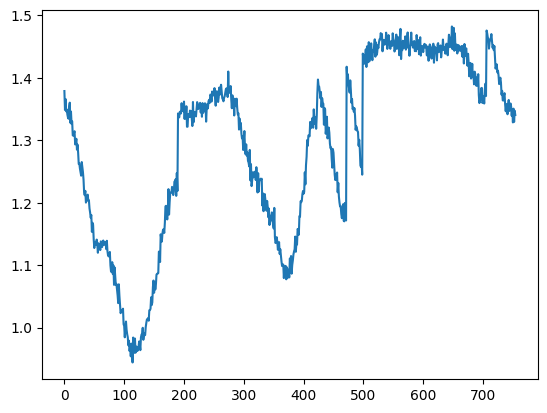

In [13]:
plt.plot(new_x_data)

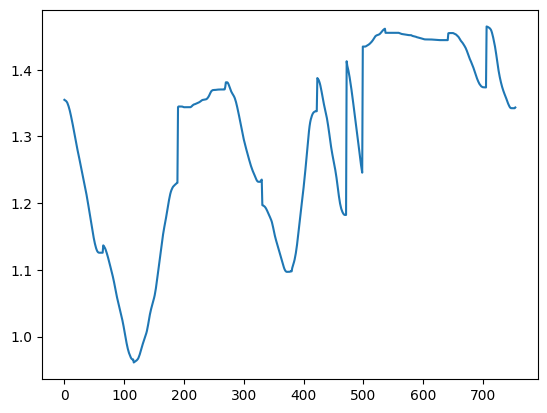

In [14]:
plt.plot(original_x_y_arrays[0])

Elije filas al azar y las aumenta con ruido gaussiano

In [15]:
SCALE = 0.01
PROPORTION = 0.2
np.random.seed(42)

def augment_data(df):
    qty_rows_to_augment = int(PROPORTION * df.shape[0])
    df_augmented = df.copy()
    
    for _ in range(qty_rows_to_augment):  # Create new N data
        target_row = np.random.randint(0, df.shape[0] - 1)  # Randomly select a row
        original_x_y_arrays = df.iloc[target_row][['x','y']].values 
        
        # Generate Gaussian noise with the same shape as the selected row
        random_noise_x = np.random.normal(0, SCALE, size=original_x_y_arrays[0].shape)
        random_noise_y = np.random.normal(0, SCALE, size=original_x_y_arrays[1].shape)
        new_x_data = original_x_y_arrays[0].shape + random_noise_x  # Add noise
        new_y_data = original_x_y_arrays[1].shape + random_noise_y  # Add noise
        
        # Convert to DataFrame and maintain original structure
        augmented_row = {
            'x': new_x_data,
            'y': new_y_data,
            'homework': df.iloc[target_row]['homework'],
            'pen_status': df.iloc[target_row]['pen_status'],
        }
        augmented_row = pd.DataFrame([augmented_row])
        
        # Concatenate the augmented row to the original dataset
        df_augmented = pd.concat([df_augmented, augmented_row], ignore_index=True, axis=0)
    
    return df_augmented	

In [16]:
df_augmented = augment_data(normalized_train_df)

In [17]:
normalized_train_df.shape, df_augmented.shape

((476, 4), (571, 4))

TODO: agregar comentario que se aumento 20% del original (476)

## Ingeniería de Características

### Extracción de Características Wavelet

Implementamos la transformación wavelet para capturar características tanto en frecuencia como temporales:

In [21]:
class WaveletTransformer(BaseEstimator, TransformerMixin):
    '''
    Custom scikit transformer for wavelet transformation of time-series data.
    '''

    def _extract_wavelet_features(self, data_list, wavelet='db4', level=10):
        """
        Aplicar la Transformada Wavelet a una lista de datos y extraer características.

        Parámetros:
        data_list = lista de datos a usar.
        wavelet = transformacion wavelet a usar (Daubechies 4 wavelet)
        level = número de veces que se realiza el proceso de descomposición en una señal o imagen
        """
        coeffs = pywt.wavedec(data_list, wavelet, level=level)
        features = []
        for coef in coeffs:
            features.extend([
                np.mean(coef),
                np.std(coef),
                np.min(coef),
                np.max(coef)
            ])
        return features
    
    def fit(self, X, y=None):
        # stateless transformer
        self.column_names = list(X.columns)

        return self
    
    def transform(self, X, y=None):
        return X.apply(self._batch_process)
    
    def _apply_transformation(self, window, column_name):
        return self._extract_wavelet_features(window)

    def _batch_process(self, column):
        return column.map(lambda col_val: self._apply_transformation(col_val, column.name))
    
    def get_feature_names_out(self, column_names):
        return self.column_names

In [22]:
wavelet_transformer = WaveletTransformer()

numerical_columns = ['x', 'y']

col_transformer = ColumnTransformer([
    ('wavelet', wavelet_transformer, numerical_columns)
], remainder='passthrough')
col_transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('wavelet', WaveletTransformer(), ['x', 'y'])])

In [23]:
wavelet_train_df = col_transformer.fit_transform(df_augmented)
column_names = [x.split('__')[-1] for x in col_transformer.get_feature_names_out()] # get column names back again
wavelet_train_df = pd.DataFrame(wavelet_train_df, columns=column_names) # transformer generates matrix, convert back to dataframe

/Users/moisesdiaz/Library/Caches/pypoetry/virtualenvs/proyecto-integrador-equipo-11-RpNcPuS5-py3.10/lib/python3.10/site-packages/pywt/_multilevel.py:43: UserWarning: Level value of 10 is too high: all coefficients will experience boundary effects.
  warnings.warn(


In [24]:
wavelet_train_df

,x,y,homework,pen_status
0,"[12.148005488777903, 4.6113439950059165, 1.858...","[-13.580025434111302, 1.370950774193397, -16.9...",4,1
1,"[43.10940807817892, 1.022130920877796, 41.0475...","[42.39905209640803, 8.715453443123613, 21.8172...",1,1
2,"[3.050218115248705, 1.6621247238320849, -0.878...","[-10.080347079861946, 0.5732943476219098, -10....",4,1
3,"[-15.887530530241712, 2.374410775749709, -21.0...","[-21.698861454684895, 1.5768433667875428, -24....",6,0
4,"[5.716625317682848, 17.310128021243035, -33.80...","[51.69157672039583, 6.411944447410347, 38.8289...",3,1
...,...,...,...,...
566,"[54656.11005251284, 0.04778331888966043, 54656...","[54656.049069048546, 0.03642223394834028, 5465...",6,0
567,"[25600.1061890809, 0.0783055755572367, 25599.9...","[25599.841231014198, 0.1252883900336434, 25599...",3,0
568,"[47519.830010511396, 0.0592690564123985, 47519...","[47520.02086169775, 0.06343797238357611, 47519...",7,0
569,"[50144.01728368786, 0.09089481395011381, 50143...","[50144.08614492718, 0.08725972278907491, 50143...",3,1


TODO: comentar que las señales x y y fueron transformadas, cada una en 44 componentes correspondientes a la transformada Wavelet.

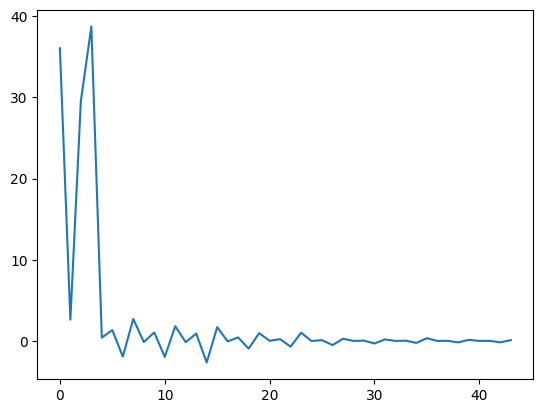

In [25]:
plt.plot(wavelet_train_df.iloc[10]['x'])

Previo a reducir la dimensionalidad, es necesario expandir los array de datos tanto X como Y. 

In [26]:
# flatten data 
x_train_data = pd.DataFrame(wavelet_train_df['x'].to_list())
y_train_data = pd.DataFrame(wavelet_train_df['y'].to_list())

### LLE

In [27]:
# Apply Locally Linear Embedding (LLE)
from sklearn.manifold import LocallyLinearEmbedding

embedding = LocallyLinearEmbedding(n_components=6, n_neighbors=4)
lle_train_data = embedding.fit_transform(x_train_data)
lle_train_data.shape

(571, 6)

TODO: justificar el número de componentes seleccionado, agregar teoría sobre LLE, para qué tipo de señales se utiliza? por qué? 

### PCA

In [28]:
from sklearn.decomposition import PCA

pca = PCA(n_components=6)
pca_train_data = pca.fit_transform(x_train_data)
pca_train_data.shape


(571, 6)

### Normalización

## Implementación del Pipeline

In [ ]:
class LLETransformer(BaseEstimator, TransformerMixin):
    '''
    Custom scikit transformer LLE transformation of time-series data.
    '''

    def fit(self, X, y=None):
        # stateless transformer
        self.x_train_data = pd.DataFrame(X['x'].to_list())
        self.y_train_data = pd.DataFrame(X['y'].to_list())
        self.column_names = list(X.columns)

        self.x_embedding = LocallyLinearEmbedding(n_components=6, n_neighbors=4)
        self.y_embedding = LocallyLinearEmbedding(n_components=6, n_neighbors=4)

        self.x_embedding = self.x_embedding.fit(x_train_data)        
        self.y_embedding = self.y_embedding.fit(x_train_data)        

        return self
    
    def transform(self, X, y=None):
        x_lle_data = self.x_embedding.transform(self.x_train_data)
        y_lle_data = self.y_embedding.transform(self.y_train_data)


        new_x_column = list(pd.DataFrame(x_lle_data).values)
        new_y_column = list(pd.DataFrame(x_lle_data).values)
        transformed_columns = pd.DataFrame([new_x_column, new_y_column]).T
        
        return transformed_columns

    
    def get_feature_names_out(self, column_names):
        return self.column_names


lle_transformer = LLETransformer()

col_transformer = ColumnTransformer([
    ('lle', lle_transformer, ['x','y'])
], remainder='passthrough')

df_lle = col_transformer.fit_transform(wavelet_train_df)
column_names = [x.split('__')[-1] for x in col_transformer.get_feature_names_out()] # get column names back again
X_train_lle = pd.DataFrame(df_lle, columns=column_names) # transformer generates matrix, convert back to dataframe

In [87]:
class PCATransformer(BaseEstimator, TransformerMixin):
    '''
    Custom scikit transformer PCA transformation of time-series data.
    '''

    def fit(self, X, y=None):
        # stateless transformer
        self.x_train_data = pd.DataFrame(X['x'].to_list())
        self.y_train_data = pd.DataFrame(X['y'].to_list())
        self.column_names = list(X.columns)

        self.x_embedding = PCA(n_components=6)
        self.y_embedding = PCA(n_components=6)

        self.x_embedding = self.x_embedding.fit(x_train_data)        
        self.y_embedding = self.y_embedding.fit(x_train_data)        

        return self
    
    def transform(self, X, y=None):
        x_pca_data = self.x_embedding.transform(self.x_train_data)
        y_pca_data = self.y_embedding.transform(self.y_train_data)


        new_x_column = list(pd.DataFrame(x_pca_data).values)
        new_y_column = list(pd.DataFrame(y_pca_data).values)
        transformed_columns = pd.DataFrame([new_x_column, new_y_column]).T
        
        return transformed_columns

    
    def get_feature_names_out(self, column_names):
        return self.column_names


pca_transformer = PCATransformer()

col_transformer = ColumnTransformer([
    ('lle', pca_transformer, ['x','y'])
], remainder='passthrough')

df_pca = col_transformer.fit_transform(wavelet_train_df)
column_names = [x.split('__')[-1] for x in col_transformer.get_feature_names_out()] # get column names back again
X_train_pca = pd.DataFrame(df_pca, columns=column_names) # transformer generates matrix, convert back to dataframe

In [99]:
def create_preprocessing_pipeline(reduction_method='lle'):
    columnas_numericas = ['x', 'y'] 
    preprocessing_pipeline = None
    if reduction_method == 'lle':
        preprocessing_pipeline = Pipeline([
            ('wavelet', WaveletTransformer()),
            ('lle', LLETransformer())
        ])
    elif reduction_method == 'pca':
        preprocessing_pipeline = Pipeline([
            ('wavelet', WaveletTransformer()),
            ('pca', PCATransformer())
        ])

    preprocesador = ColumnTransformer(
        transformers=[
            ('numericas', preprocessing_pipeline, columnas_numericas)
        ],
        remainder='passthrough'
    )
    return preprocesador

In [106]:
# Crear y ajustar pipeline
pipeline = create_preprocessing_pipeline(reduction_method='lle')
X_train_preprocessed = pipeline.fit_transform(X_train)
X_val_preprocessed = pipeline.transform(X_val)
# X_test_preprocessed = pipeline.transform(X_test)

# # Convertir a DataFrame para mejor manejo
# columns = [f'caracteristica_{i}' for i in range(X_train_transformado.shape[1])]
# X_train_transformado = pd.DataFrame(X_train_transformado, columns=columns)
# X_val_transformado = pd.DataFrame(X_val_transformado, columns=columns)
# X_test_transformado = pd.DataFrame(X_test_transformado, columns=columns)

# Mostrar dimensiones y primeras filas
print("Dimensiones después de la transformación:")
# print(f"Train: {X_train_preprocessed.shape}")
# print(f"Validación: {X_val_transformado.shape}")
# print(f"Test: {X_test_transformado.shape}")



/Users/moisesdiaz/Library/Caches/pypoetry/virtualenvs/proyecto-integrador-equipo-11-RpNcPuS5-py3.10/lib/python3.10/site-packages/pywt/_multilevel.py:43: UserWarning: Level value of 10 is too high: all coefficients will experience boundary effects.
  warnings.warn(
/Users/moisesdiaz/Library/Caches/pypoetry/virtualenvs/proyecto-integrador-equipo-11-RpNcPuS5-py3.10/lib/python3.10/site-packages/pywt/_multilevel.py:43: UserWarning: Level value of 10 is too high: all coefficients will experience boundary effects.
  warnings.warn(
/Users/moisesdiaz/Library/Caches/pypoetry/virtualenvs/proyecto-integrador-equipo-11-RpNcPuS5-py3.10/lib/python3.10/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 476 and the array at index 1 has size 556

# Shuffle y partición de datos

## Visualización y Análisis 

In [16]:
def visualizar_transformaciones(X_transformado):
    """
    Genera visualizaciones para validar las transformaciones
    """
    # Seleccionamos las primeras 20 características para visualización
    X_vis = X_transformado.iloc[:, :20]
    
    # Creamos la figura con dos subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # 1. Distribución de características usando violinplot
    sns.violinplot(data=X_vis, ax=ax1)
    ax1.set_title('Distribución de las Primeras 20 Características')
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
    
    # 2. Matriz de correlación
    sns.heatmap(X_vis.corr(), 
                cmap='coolwarm', 
                center=0,
                ax=ax2)
    ax2.set_title('Correlación entre Características')
    
    plt.tight_layout()
    return fig

# Visualizar características extraídas para cada tipo de señal
def visualizar_caracteristicas_por_tipo(X_transformado):
    """
    Visualiza las características extraídas agrupadas por tipo de señal original
    """
    tipos_señal = ['x', 'y', 'azimuth', 'altitude', 'pressure']
    
    for tipo in tipos_señal:
        # Seleccionar columnas relacionadas con este tipo de señal
        cols = [col for col in X_transformado.columns if tipo in col]
        if cols:
            plt.figure(figsize=(15, 6))
            
            # Boxplot para las características
            sns.boxplot(data=X_transformado[cols])
            plt.title(f'Características extraídas de la señal {tipo}')
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()

# Función para visualizar la descomposición wavelet
def visualizar_wavelet(señal_original, nivel=3, wavelet='db4'):
    """
    Visualiza la descomposición wavelet de una señal
    """
    # Realizar la descomposición wavelet
    coefs = pywt.wavedec(señal_original, wavelet, level=nivel)
    
    # Crear la figura
    fig, axes = plt.subplots(nivel + 2, 1, figsize=(15, 3*(nivel+2)))
    
    # Plotear señal original
    axes[0].plot(señal_original)
    axes[0].set_title('Señal Original')
    
    # Plotear coeficientes de aproximación
    axes[1].plot(coefs[0])
    axes[1].set_title('Coeficientes de Aproximación')
    
    # Plotear coeficientes de detalle
    for i, coef in enumerate(coefs[1:], 2):
        axes[i].plot(coef)
        axes[i].set_title(f'Coeficientes de Detalle Nivel {i-1}')
    
    plt.tight_layout()
    return fig


C:\Users\arman\AppData\Local\Temp\ipykernel_19604\759826518.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
C:\Users\arman\AppData\Local\pypoetry\Cache\virtualenvs\proyecto-integrador-equipo-11-WxcN3L0e-py3.12\Lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
C:\Users\arman\AppData\Local\pypoetry\Cache\virtualenvs\proyecto-integrador-equipo-11-WxcN3L0e-py3.12\Lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


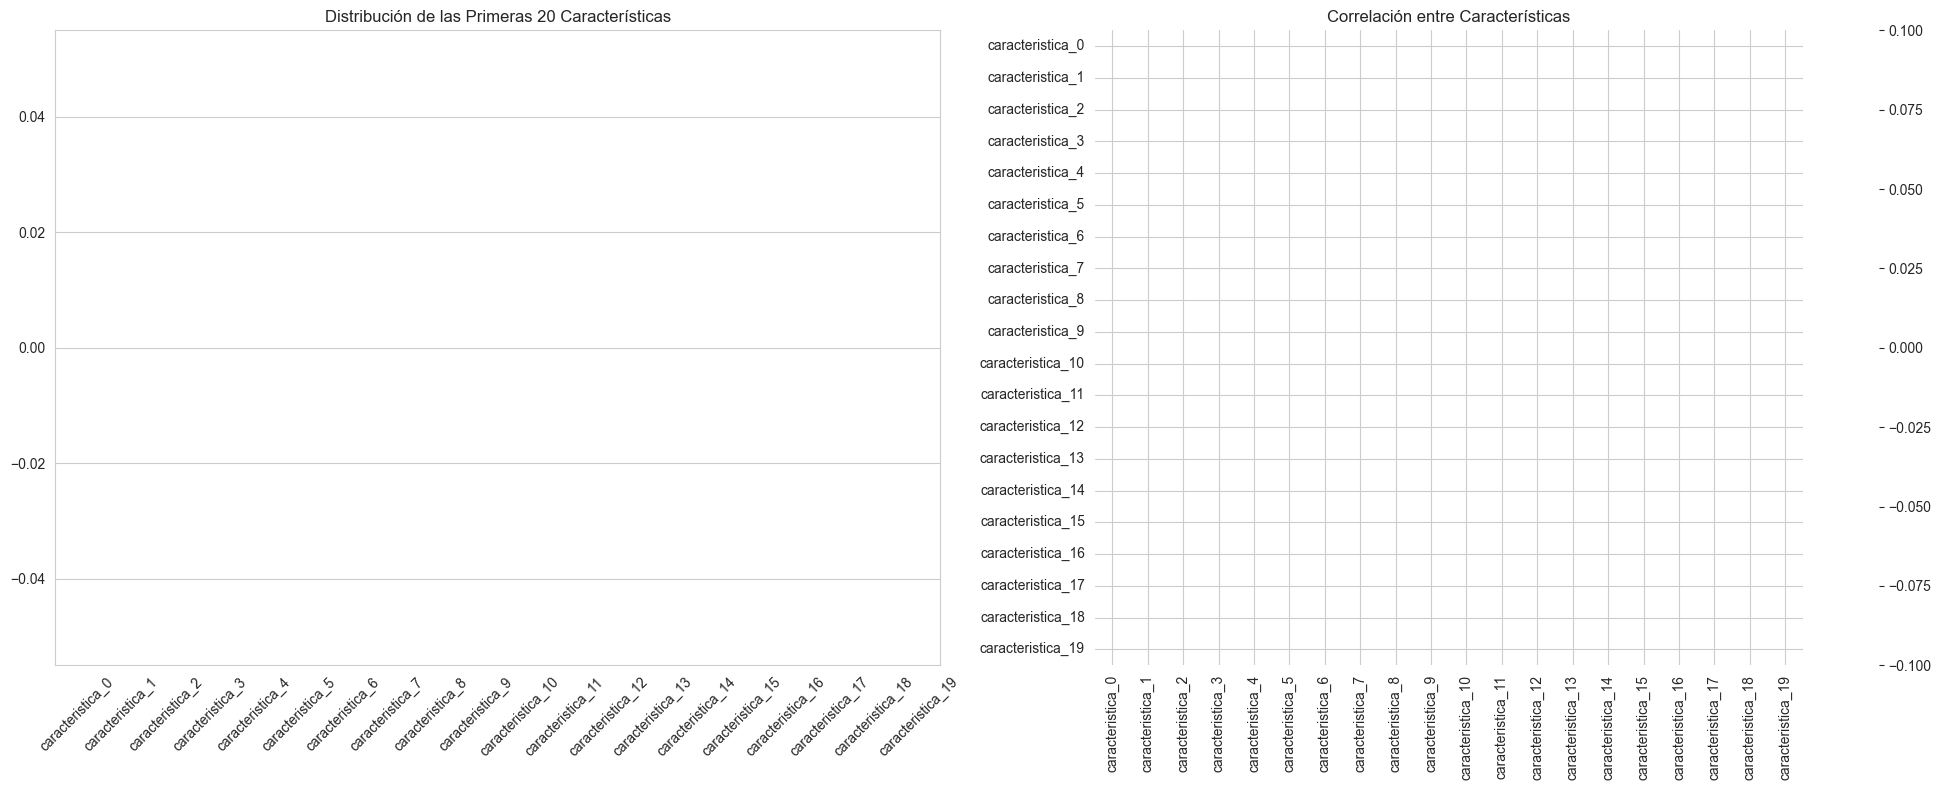

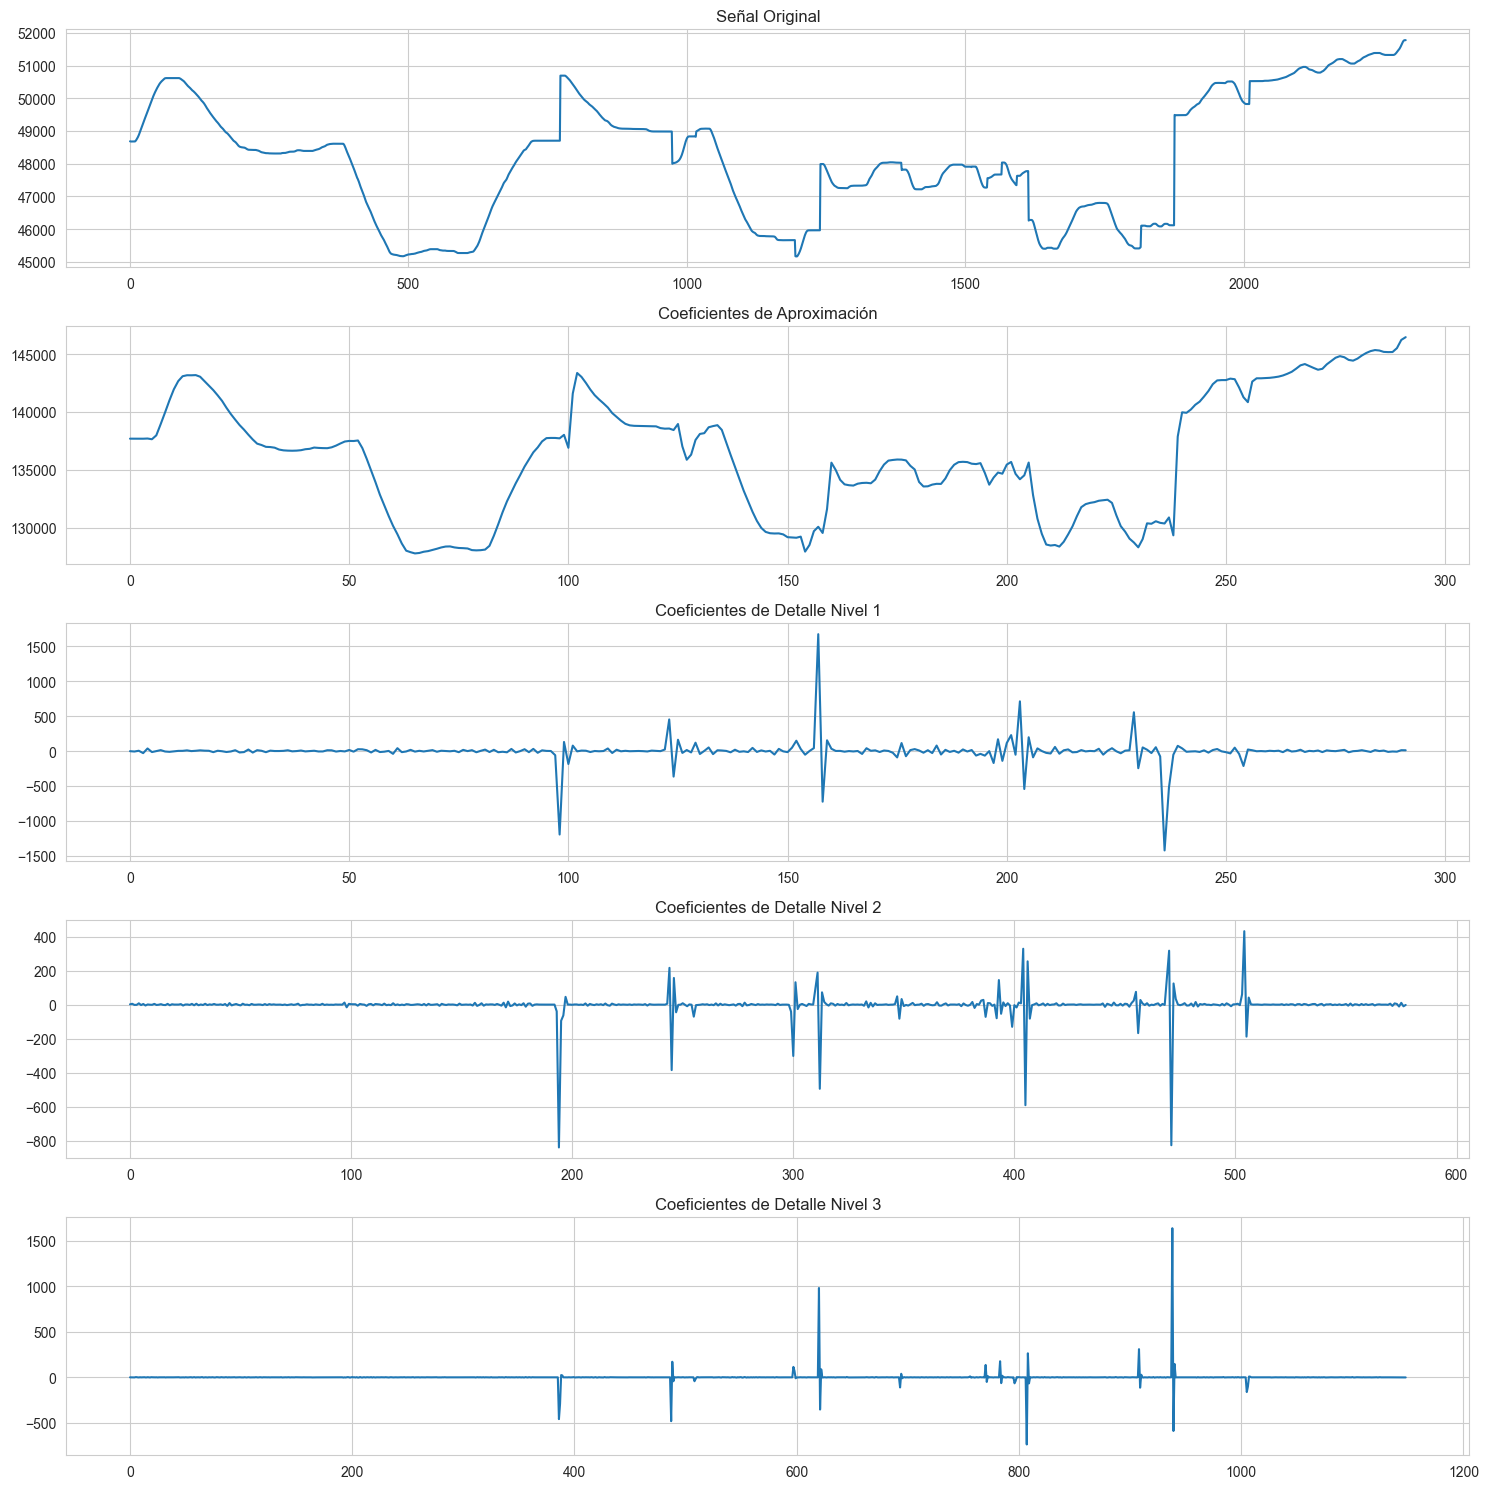

In [17]:
# Ejecutar visualizaciones
try:
    # Visualización general de características
    fig1 = visualizar_transformaciones(X_train_transformado)
    plt.show()
    
    # Visualización por tipo de señal
    visualizar_caracteristicas_por_tipo(X_train_transformado)
    
    # Ejemplo de descomposición wavelet para una señal
    señal_ejemplo = X_train['x'].iloc[0]  # Primera señal x
    fig3 = visualizar_wavelet(señal_ejemplo)
    plt.show()
    
except Exception as e:
    print(f"Error en la visualización: {str(e)}")

## Conclusiones

## Referencias